In [145]:
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [146]:
print(tf.__version__)
print(tf.config.list_physical_devices())

2.9.2
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [147]:
import pandas_datareader
import datetime

In [148]:
pre_days = 2
mem_his_days = 5
epoch = 500
train_rate = 0.99

In [149]:
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2023, 7, 18)

df = pandas_datareader.data.DataReader('NVDA', 'stooq', start, end)
df.dropna(inplace=True)
df.sort_index(inplace=True)

# normalize = lambda x: (x - x.min()) / (x.max() - x.min())

df['PreHigh'] = df['High'].shift(1)
df["Change"] = df['High'] / df['PreHigh']
print(df.head())

def change2label(x):
    if x < 0.91:
       return 0
    elif x < 0.92:
       return 1
    elif x < 0.93:
       return 2
    elif x < 0.94:
       return 3
    elif x < 0.95:
       return 4
    elif x < 0.96:
       return 5
    elif x < 0.97:
       return 6
    elif x < 0.98:
       return 7
    elif x < 0.99:
       return 8
    elif x < 1.:
       return 9
    elif x < 1.1:
       return 10
    elif x < 1.2:
       return 11
    elif x < 1.3:
       return 12
    elif x < 1.4:
       return 13
    elif x < 1.5:
       return 14
    elif x < 1.6:
       return 15
    elif x < 1.7:
       return 16
    elif x < 1.8:
       return 17
    elif x < 1.9:
       return 18
    return 19

df = df.dropna()
change = np.array(df['Change']).astype(np.float32)
df['Change'] = df['Change'].apply(change2label)
print(df.head())
df = df.drop('High', axis=1)
df = df.drop('PreHigh', axis=1)
# df = df.drop('Low', axis=1)
# df = df.drop('Open', axis=1)
# df = df.drop('Close', axis=1)
print(df.head())


scaler = MinMaxScaler((0, 1))

sca = scaler.fit_transform(df.iloc[:, :-1])
label = np.array(df.iloc[:, -1])
print(sca)
print(label)

                Open      High       Low     Close        Volume   PreHigh  \
Date                                                                         
2000-01-03  0.903909  0.910803  0.844454  0.894816  8.247598e+06       NaN   
2000-01-04  0.878828  0.881027  0.826068  0.871934  8.229294e+06  0.910803   
2000-01-05  0.846752  0.860442  0.830764  0.842157  5.148870e+06  0.881027   
2000-01-06  0.842157  0.842157  0.754923  0.787099  3.289615e+06  0.860442   
2000-01-07  0.784800  0.809981  0.773308  0.800788  2.000436e+06  0.842157   

              Change  
Date                  
2000-01-03       NaN  
2000-01-04  0.967308  
2000-01-05  0.976635  
2000-01-06  0.978749  
2000-01-07  0.961793  
                Open      High       Low     Close        Volume   PreHigh  \
Date                                                                         
2000-01-04  0.878828  0.881027  0.826068  0.871934  8.229294e+06  0.910803   
2000-01-05  0.846752  0.860442  0.830764  0.842157  5.1488

In [150]:
deq = collections.deque()

x = []
for row in sca:
    deq.append(list(row))
    if len(deq) > mem_his_days:
        deq.popleft()
    if len(deq) == mem_his_days:
        x.append(list(deq))
x = x[:-pre_days]
y = label[mem_his_days-1:-pre_days]
change = change[mem_his_days-1:-pre_days]

x, y = np.array(x).reshape(-1,mem_his_days,4,1), np.array(y)
print(x.shape)
print(y.shape)

(5913, 5, 4, 1)
(5913,)


In [151]:
total_num = len(x)
train_num = int(total_num * train_rate)
print(train_num)

5853


In [152]:
x_train, y_train, change_train = x[:train_num], y[:train_num], change[:train_num]
x_test, y_test, change_test = x[train_num:], y[train_num:], change[train_num:]

batch_size = 128

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(train_num).batch(batch_size=batch_size).prefetch(tf.data.experimental.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.shuffle(total_num - train_num).batch(batch_size=batch_size).prefetch(tf.data.experimental.AUTOTUNE)

sample = next(iter(train_ds))
print('x_train.shape:', sample[0].shape)
print('y_train.shape:', sample[1].shape)

x_train.shape: (128, 5, 4, 1)
y_train.shape: (128,)


In [153]:
input_shape = sample[0].shape[-3:]

model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32,4,input_shape=input_shape,padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(64,4,padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(128,4,padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dense(20,activation='softmax'))
model.build(input_shape=[None,mem_his_days,4])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 5, 4, 32)          544       
                                                                 
 batch_normalization_28 (Bat  (None, 5, 4, 32)         128       
 chNormalization)                                                
                                                                 
 re_lu_28 (ReLU)             (None, 5, 4, 32)          0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 2, 2, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 2, 2, 64)          32832     
                                                                 
 batch_normalization_29 (Bat  (None, 2, 2, 64)        

In [154]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = tf.keras.metrics.SparseCategoricalAccuracy()

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=[metrics])

# model.compile(optimizer=tf.keras.optimizers.RMSprop(),
#               loss=tf.keras.losses.MeanAbsoluteError(),
#               metrics=tf.keras.losses.MeanSquaredLogarithmicError())

def lr_schedule(epoch):
    if epoch > 350:
        return 0.00001
    if epoch > 200:
        return 0.00005
    if epoch > 150:
        return 0.0001
    if epoch > 100:
        return 0.0002
    if epoch > 50:
        return 0.0005
    return 0.001
        
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule,verbose=True)

history = model.fit(train_ds,
                    epochs=epoch,
                    validation_data=test_ds,
                    callbacks=[lr_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500


2023-07-18 22:46:08.731589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 3s 42ms/step - loss: 2.2083 - sparse_categorical_accuracy: 0.4071 - val_loss: 2.6587 - val_sparse_categorical_accuracy: 0.4833 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/500
 1/46 [..............................] - ETA: 0s - loss: 1.7263 - sparse_categorical_accuracy: 0.5312

2023-07-18 22:46:10.860080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 1s 15ms/step - loss: 1.6303 - sparse_categorical_accuracy: 0.4999 - val_loss: 2.2534 - val_sparse_categorical_accuracy: 0.4833 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/500
46/46 [==============================] - 1s 14ms/step - loss: 1.5388 - sparse_categorical_accuracy: 0.5001 - val_loss: 1.9212 - val_sparse_categorical_accuracy: 0.4833 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/500
46/46 [==============================] - 1s 14ms/step - loss: 1.5041 - sparse_categorical_accuracy: 0.5033 - val_loss: 1.5795 - val_sparse_categorical_accuracy: 0.4833 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/500
46/46 [==============================] - 1s 14ms/step - loss: 1.4784 - sparse_categorical_accuracy: 0.5052 - val_loss: 1.4780 - val_sparse_categorical_accuracy: 0.4833 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning

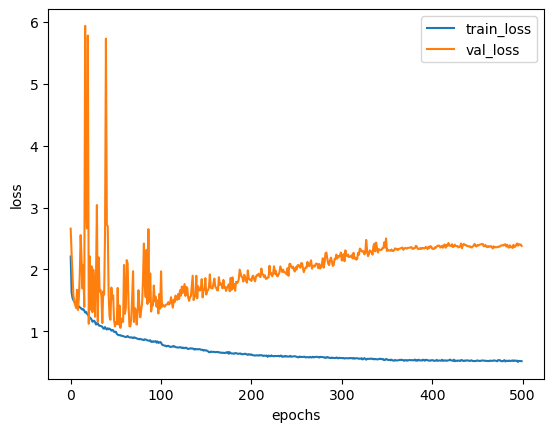

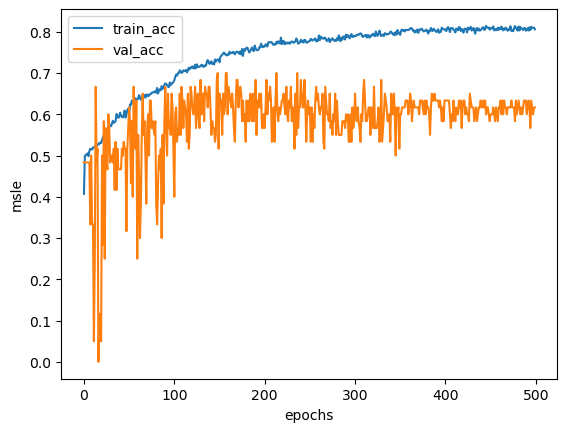

In [155]:
train_acc = history.history['sparse_categorical_accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_sparse_categorical_accuracy']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(range(epoch), train_loss, label='train_loss')
plt.plot(range(epoch), val_loss, label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(range(epoch), train_acc, label='train_acc')
plt.plot(range(epoch), val_acc, label='val_acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('msle')
plt.show()

2/2 [==============================] - 0s 56ms/step
[10  9 10  8  9  9 10 10 10 10  9  7  9 10 10  9 10  9  8 10 10 10 10  9
  8  9 10 11  9 10  8  9 10  6  9  9 10 10 10 10 10  9 10  9  9  6  9  6
 10  6  9 10  9 10  9 10  9  9 10 10]


2023-07-18 22:51:44.932629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


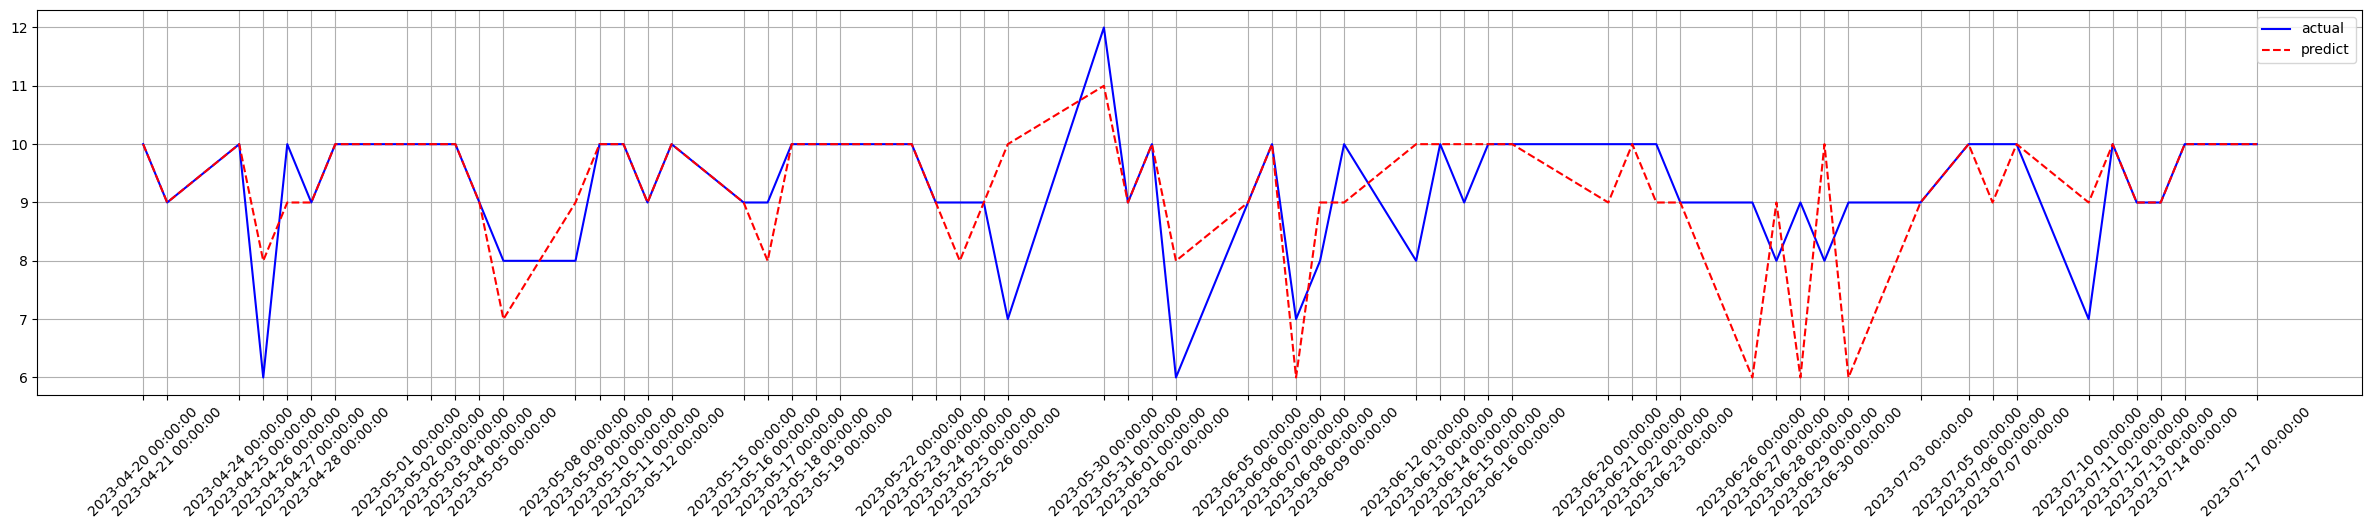

In [156]:
model.evaluate(test_ds)

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

df_time = df.index[-len(y_test):]

fig = plt.figure(figsize=(30, 5))
axes = fig.add_subplot(111)
axes.plot(df_time, y_test, 'b-', label='actual')
axes.plot(df_time, y_pred, 'r--', label='predict')
print(y_pred)
axes.set_xticks(df_time[::1])
axes.set_xticklabels(df_time[::1],rotation=45)

plt.legend()
plt.grid()
plt.show()

In [157]:
price_actual = list()
price_pred = list()
price_actual.append(1.0)
price_pred.append(1.0)
def label2change(label):
    if label == 0:
        return 0.905
    elif label == 1:
        return 0.915
    elif label == 2:
        return 0.925
    elif label == 3:
        return 0.935
    elif label == 4:
        return 0.945
    elif label == 5:
        return 0.955
    elif label == 6:
        return 0.965
    elif label == 7:
        return 0.975
    elif label == 8:
        return 0.985
    elif label == 9:
        return 0.995
    elif label == 10:
        return 1.005
    elif label == 11:
        return 1.015
    elif label == 12:
        return 1.025
    elif label == 13:
        return 1.035
    elif label == 14:
        return 1.045
    elif label == 15:
        return 1.055
    elif label == 16:
        return 1.065
    elif label == 17:
        return 1.075
    elif label == 18:
        return 1.085
    elif label == 19:
        return 1.095
    return 0
    

for idx in range(1, len(y_test)):
    price_actual.append(price_actual[idx-1] * change_test[idx])
    price_pred.append(price_pred[idx-1] * label2change(y_pred[idx]))
print(price_actual)
print(price_pred)

[1.0, 0.9960867762565613, 0.9971540365153544, 0.9670223872843904, 0.9735321388677222, 0.9692991245226568, 0.9722517598739484, 0.9781215883817075, 0.9874776670364436, 1.0337402559123718, 1.0258267024343783, 1.009142634996744, 0.9910707513455985, 1.0229455203523914, 1.0394876723604913, 1.0307007471820728, 1.0356811234359493, 1.02988244559519, 1.0238347801984047, 1.0305583045747457, 1.0626109149597787, 1.0743148753174099, 1.132265786968202, 1.1234433114593212, 1.1213088167376655, 1.113055536702856, 1.0888292929053096, 1.4044820135021552, 1.3934539119070681, 1.4919241624357868, 1.4334752265955597, 1.4247594813304, 1.4407680110117627, 1.4075069395295217, 1.3930981534195856, 1.4051578421909556, 1.3825679823642587, 1.4126996157775515, 1.4062602404713642, 1.462148160313229, 1.5297041655673023, 1.5399851551129478, 1.5553534161253977, 1.5649229299843197, 1.5515824998768242, 1.5448411516849656, 1.5229094226549151, 1.5213085592829503, 1.4919951152714364, 1.4886155146055298, 1.4798997239761607, 1.5

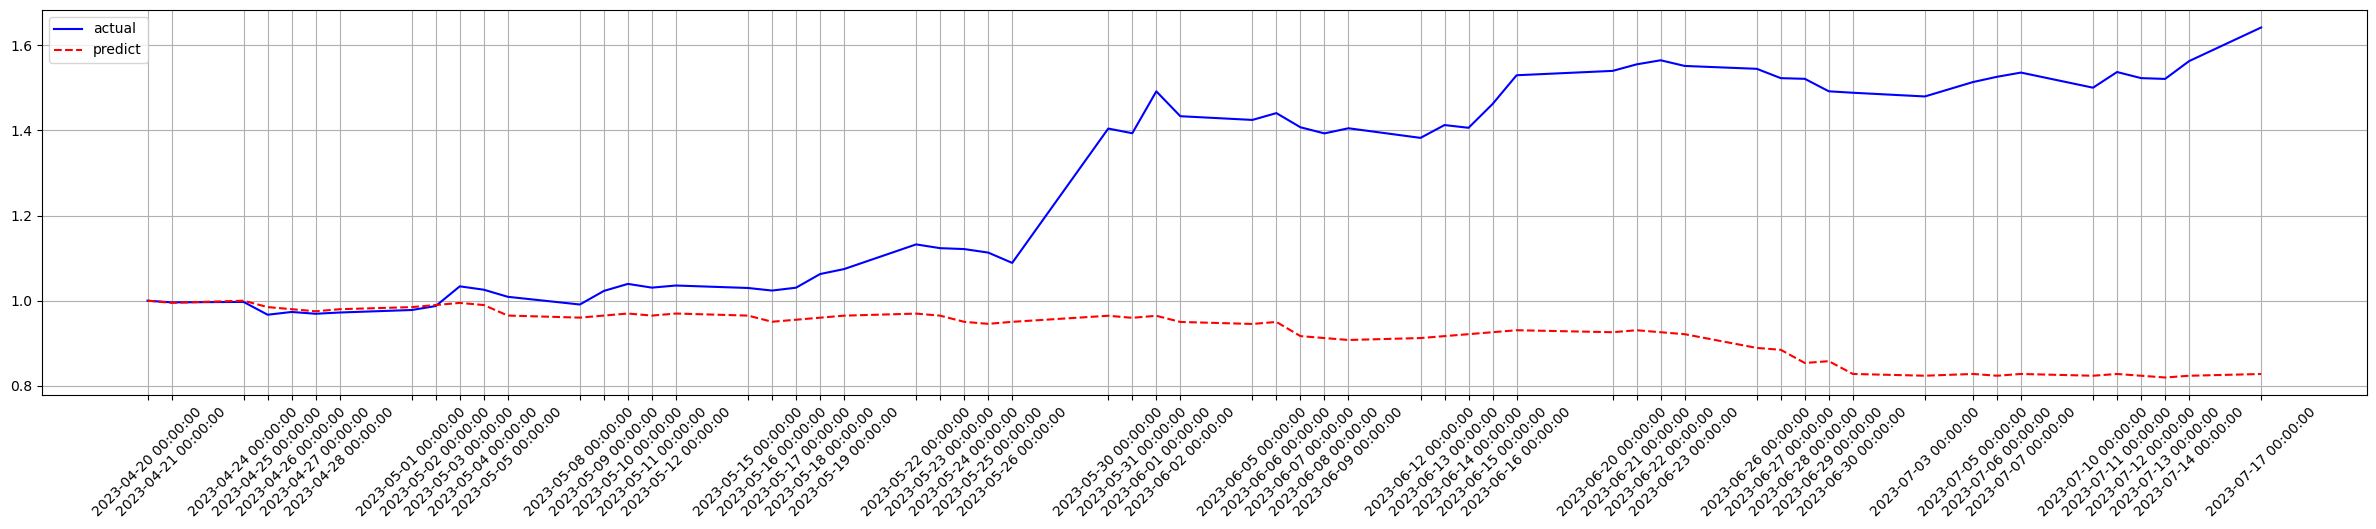

In [158]:
df_time = df.index[-len(y_test):]

fig = plt.figure(figsize=(30, 5))
axes = fig.add_subplot(111)
axes.plot(df_time, price_actual, 'b-', label='actual')
axes.plot(df_time, price_pred, 'r--', label='predict')

axes.set_xticks(df_time[::1])
axes.set_xticklabels(df_time[::1],rotation=45)

plt.legend()
plt.grid()
plt.show()

In [159]:
actual_profit_rate = 1
for idx in range(0, len(y_pred)):
    if y_pred[idx] >= 10:
        actual_profit_rate *= change_test[idx]
print(actual_profit_rate)

2.1724418238167216
